<a href="https://colab.research.google.com/github/Anvar-baba/pythonProject-7/blob/main/PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,594 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,168 

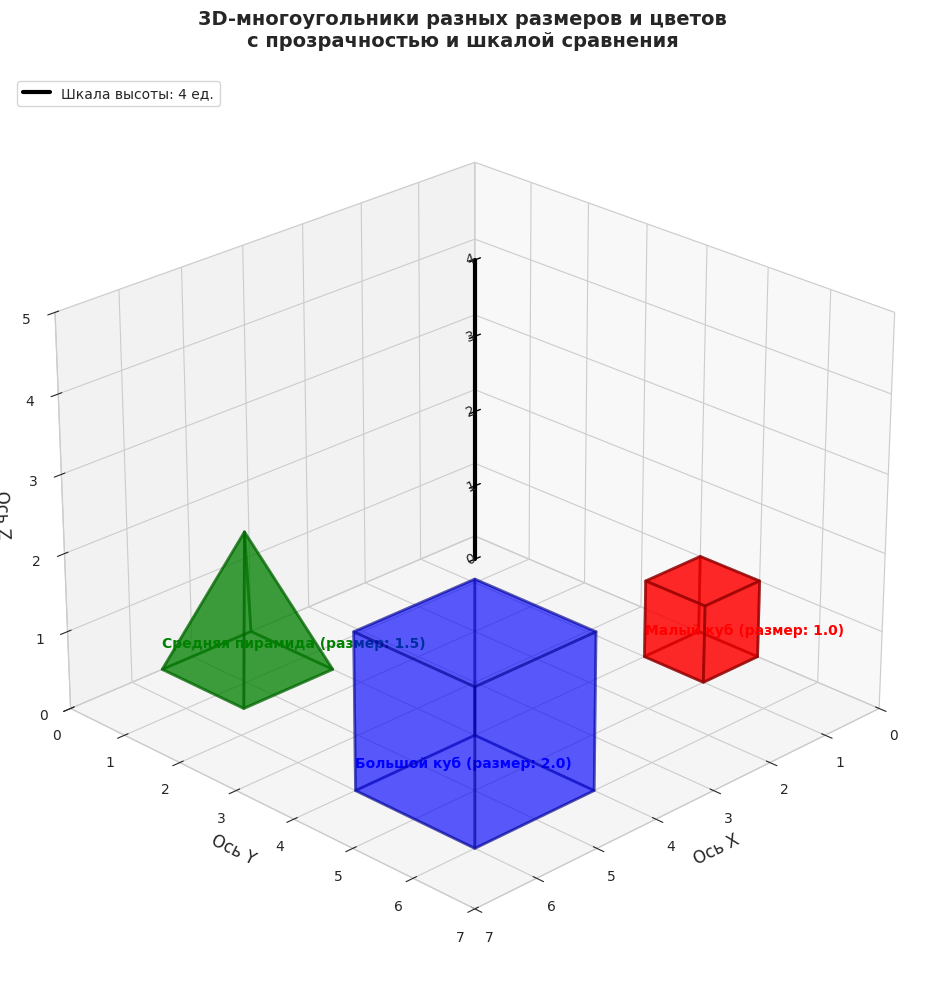


📈 АНАЛИТИКА ДАННЫХ:
Статистика объектов:
Количество объектов: 3
Средний размер: 1.50
Минимальный размер: 1.00
Максимальный размер: 2.00
Общий объем: 12.38

Детальная информация об объектах:
- Малый куб: размер 1.0, объем 1.00, прозрачность 0.6
- Средняя пирамида: размер 1.5, объем 3.38, прозрачность 0.5
- Большой куб: размер 2.0, объем 8.00, прозрачность 0.4

✅ Spark сессия остановлена.

🎉 Визуализация завершена успешно!


In [ ]:
# Установка и настройка Java и Spark в Google Colab
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Устанавливаем PySpark
!pip install pyspark -q

# Настраиваем переменные окружения
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd

print("✅ Библиотеки успешно загружены!")

# Инициализация Spark сессии с правильными настройками для Colab
try:
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("3DVisualization") \
        .config("spark.driver.memory", "512m") \
        .config("spark.executor.memory", "512m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .getOrCreate()

    print("✅ Spark сессия создана!")

    # Тестируем Spark
    test_df = spark.range(5)
    print("✅ Spark работает корректно!")

except Exception as e:
    print(f"❌ Ошибка при создании Spark сессии: {e}")
    print("Продолжаем без Spark...")
    spark = None

# Если Spark не работает, создаем данные напрямую через Pandas
if spark is None:
    print("Используем альтернативный метод без Spark...")

    objects_data = {
        'object_id': [1, 2, 3],
        'object_name': ['Малый куб', 'Средняя пирамида', 'Большой куб'],
        'size_factor': [1.0, 1.5, 2.0],
        'color': ['red', 'green', 'blue'],
        'position_x': [0.0, 4.0, 4.0],
        'position_y': [4.0, 0.0, 4.0],
        'transparency': [0.6, 0.5, 0.4]
    }

    objects_pd = pd.DataFrame(objects_data)
    objects_pd['volume'] = objects_pd['size_factor'] ** 3
    objects_pd['label'] = objects_pd['object_name'] + ' (размер: ' + objects_pd['size_factor'].astype(str) + ')'

else:
    # Создаем данные через Spark (оригинальный подход)
    schema = StructType([
        StructField("object_id", IntegerType(), True),
        StructField("object_name", StringType(), True),
        StructField("size_factor", DoubleType(), True),
        StructField("color", StringType(), True),
        StructField("position_x", DoubleType(), True),
        StructField("position_y", DoubleType(), True),
        StructField("transparency", DoubleType(), True)
    ])

    objects_data = [
        (1, "Малый куб", 1.0, "red", 0.0, 4.0, 0.6),
        (2, "Средняя пирамида", 1.5, "green", 4.0, 0.0, 0.5),
        (3, "Большой куб", 2.0, "blue", 4.0, 4.0, 0.4),
    ]

    objects_df = spark.createDataFrame(objects_data, schema)

    # Вычисляем дополнительные характеристики
    objects_processed = objects_df.withColumn(
        "volume", F.pow(F.col("size_factor"), 3)
    ).withColumn(
        "label", F.concat(F.col("object_name"), F.lit(" (размер: "),
                         F.format_number("size_factor", 1), F.lit(")"))
    )

    # Конвертируем в Pandas для визуализации
    objects_pd = objects_processed.toPandas()

print("📊 Данные для визуализации:")
print(objects_pd)

# Функции для создания 3D-объектов
def create_cube_vertices(size, pos_x, pos_y):
    base_vertices = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]
    ])
    return base_vertices * size + [pos_x, pos_y, 0]

def create_pyramid_vertices(size, pos_x, pos_y):
    base_vertices = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
        [0.5, 0.5, 1.2]
    ])
    return base_vertices * size + [pos_x, pos_y, 0]

# Грани для 3D-объектов
cube_faces = [
    [0, 1, 2, 3], [4, 5, 6, 7],
    [0, 1, 5, 4], [1, 2, 6, 5],
    [2, 3, 7, 6], [3, 0, 4, 7]
]

pyramid_faces = [
    [0, 1, 2, 3],
    [0, 1, 4], [1, 2, 4],
    [2, 3, 4], [3, 0, 4]
]

# СОЗДАНИЕ 3D-ВИЗУАЛИЗАЦИИ
print("🎨 Создание 3D-визуализации...")

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Создаем объекты на основе данных
for _, obj in objects_pd.iterrows():
    if "куб" in obj["object_name"]:
        vertices = create_cube_vertices(obj["size_factor"], obj["position_x"], obj["position_y"])
        faces = cube_faces
    elif "пирамида" in obj["object_name"]:
        vertices = create_pyramid_vertices(obj["size_factor"], obj["position_x"], obj["position_y"])
        faces = pyramid_faces
    else:
        vertices = create_cube_vertices(obj["size_factor"], obj["position_x"], obj["position_y"])
        faces = cube_faces

    # Определяем цвет граней
    edge_color = 'dark' + obj["color"] if obj["color"] in ['red', 'green', 'blue'] else 'black'

    # Создаем полигон
    poly = Poly3DCollection([vertices[face] for face in faces],
                           alpha=obj["transparency"],
                           linewidths=2,
                           edgecolor=edge_color)
    poly.set_facecolor(obj["color"])
    ax.add_collection3d(poly)

    # Добавляем подпись
    ax.text(vertices[1][0], vertices[1][1], vertices[1][2] + 0.3,
            obj["label"], color=obj["color"], fontsize=10, fontweight='bold')

# Настройка осей
ax.set_xlabel('Ось X', fontsize=12)
ax.set_ylabel('Ось Y', fontsize=12)
ax.set_zlabel('Ось Z', fontsize=12)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.set_zlim([0, 5])

# Добавление шкалы
scale_length = 4
ax.plot([0.5, 0.5], [0.5, 0.5], [0, scale_length], 'k-', lw=3,
        label=f'Шкала высоты: {scale_length} ед.')

# Деления на шкале
for i in range(scale_length + 1):
    ax.plot([0.4, 0.6], [0.5, 0.5], [i, i], 'k-', lw=1)
    ax.text(0.7, 0.5, i, f'{i}', zdir='x')

# Легенда
ax.legend(loc='upper left')

# Угол обзора 45 градусов
ax.view_init(elev=25, azim=45)

plt.title('3D-многоугольники разных размеров и цветов\nс прозрачностью и шкалой сравнения',
          pad=20, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Аналитика данных
print("\n" + "="*50)
print("📈 АНАЛИТИКА ДАННЫХ:")
print("="*50)

print("Статистика объектов:")
print(f"Количество объектов: {len(objects_pd)}")
print(f"Средний размер: {objects_pd['size_factor'].mean():.2f}")
print(f"Минимальный размер: {objects_pd['size_factor'].min():.2f}")
print(f"Максимальный размер: {objects_pd['size_factor'].max():.2f}")
print(f"Общий объем: {objects_pd['volume'].sum():.2f}")

print("\nДетальная информация об объектах:")
for _, obj in objects_pd.iterrows():
    print(f"- {obj['object_name']}: размер {obj['size_factor']}, объем {obj['volume']:.2f}, прозрачность {obj['transparency']}")

# Останавливаем Spark сессию если она была создана
if spark is not None:
    spark.stop()
    print("\n✅ Spark сессия остановлена.")

print("\n🎉 Визуализация завершена успешно!")